# LSHForest for Airbnb dataset

Setting Spark-related variables

In [1]:
import os
os.environ["SPARK_HOME"] = '/home/******/Documents/spark/spark-2.3.0-bin-hadoop2.7'
os.environ["IPYTHON"] = '1'
os.environ["PYSPARK_PYTHON"] = '/usr/bin/python3'
os.environ["PYSPARK_DRIVER_PYTHON"] = 'ipython3'
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = 'notebook'

In [2]:
from pyspark import SparkContext
sc = SparkContext("local", "TF-IDF")

In [3]:
from pyspark.sql.session import SparkSession
spark = SparkSession(sc)

### Loading Data
Here we are reading two datasets for Amsterdam.

In [4]:
from pyspark.sql.types import *
listings = spark.read.csv("data/listings.csv",header=True) 
reviews = spark.read.csv("data/reviews.csv",header=True) 

In [5]:
print(listings.head(1))
print(reviews.head(1))

[Row(id='20621335', name='Clean room Amsterdam. Metro 3min walk.Free parking', host_id='25403329', host_name='Victor', neighbourhood_group=None, neighbourhood='Bijlmer-Oost', latitude='52.319172968245226', longitude='4.981150531499213', room_type='Private room', price='52', minimum_nights='3', number_of_reviews='23', last_review='2017-11-28', reviews_per_month='6.83', calculated_host_listings_count='1', availability_365='12')]
[Row(listing_id='18285386', date='2017-04-29')]


In [6]:
print(listings.count(), reviews.count())

18556 337816


Let's join two datasets

In [7]:
joined = listings.join(reviews, listings.id == reviews.listing_id)

In [8]:
type(joined)
joined.head(1)
# joined.show()

[Row(id='18285386', name='Vintage Apartment close to the Rembrandtpark', host_id='65859990', host_name='Martijn', neighbourhood_group=None, neighbourhood='De Baarsjes - Oud-West', latitude='52.359685090340044', longitude='4.849732024829394', room_type='Entire home/apt', price='110', minimum_nights='2', number_of_reviews='7', last_review='2017-10-19', reviews_per_month='0.95', calculated_host_listings_count='58', availability_365='0', listing_id='18285386', date='2017-04-29')]

In [9]:
avg = joined.agg({"price":"avg"})
avg.show()
avg = avg.first()[0]

+------------------+
|        avg(price)|
+------------------+
|127.29295807184384|
+------------------+



In [10]:
type(avg)

float

In [11]:
joined = joined.withColumn("price_deviation", joined.price/avg)

In [12]:
joined.head(1)

[Row(id='18285386', name='Vintage Apartment close to the Rembrandtpark', host_id='65859990', host_name='Martijn', neighbourhood_group=None, neighbourhood='De Baarsjes - Oud-West', latitude='52.359685090340044', longitude='4.849732024829394', room_type='Entire home/apt', price='110', minimum_nights='2', number_of_reviews='7', last_review='2017-10-19', reviews_per_month='0.95', calculated_host_listings_count='58', availability_365='0', listing_id='18285386', date='2017-04-29', price_deviation=0.8641483524792963)]

In [13]:
from pyspark.sql.functions import when
joined = joined.withColumn("price_bucket", when(joined.price>avg, "H").otherwise("L"))
# udf = udf(lambda x: "H" if x>avg else "L")
# joined = joined.withColumn("price_bucket",udf(joined.price))

In [14]:
joined.head(1)

[Row(id='18285386', name='Vintage Apartment close to the Rembrandtpark', host_id='65859990', host_name='Martijn', neighbourhood_group=None, neighbourhood='De Baarsjes - Oud-West', latitude='52.359685090340044', longitude='4.849732024829394', room_type='Entire home/apt', price='110', minimum_nights='2', number_of_reviews='7', last_review='2017-10-19', reviews_per_month='0.95', calculated_host_listings_count='58', availability_365='0', listing_id='18285386', date='2017-04-29', price_deviation=0.8641483524792963, price_bucket='L')]

In [15]:
#joined.toPandas().to_csv('output/result.csv')

In [16]:
# filter Null
from pyspark.sql.functions import col
group_nh = joined.where(col("neighbourhood").isNotNull()).groupby("neighbourhood").agg({"price":"avg"})

In [17]:
group_nh.show()

+--------------------+------------------+
|       neighbourhood|        avg(price)|
+--------------------+------------------+
|           Oud-Noord|130.93894713848843|
|De Baarsjes - Oud...|122.37392061405068|
|       Bos en Lommer| 95.29638905066977|
|              Osdorp| 84.53846153846153|
|        Centrum-Oost|151.33991886623465|
|De Pijp - Riviere...|126.36769410846664|
|          Westerpark| 126.0908345913306|
|            Oud-Oost|115.57246504007958|
|Geuzenveld - Slot...| 85.75564853556486|
|Oostelijk Havenge...|119.46980833963042|
|                Zuid|149.55366458998125|
|        Centrum-West|150.86658591451808|
|          Noord-Oost| 86.61065573770492|
|          Noord-West| 83.18913329573228|
|IJburg - Zeeburge...|113.56179580516554|
|De Aker - Nieuw S...| 82.38548878427028|
|     Watergraafsmeer|123.47660775285905|
|        Bijlmer-Oost| 67.12191011235954|
|     Bijlmer-Centrum| 71.35648148148148|
|Gaasperdam - Drie...| 79.30756111426948|
+--------------------+------------

In [18]:
group_nh.count()

22

In [19]:
#group_nh.toPandas().to_csv('result_grouped.csv')

## Here the home assignmnet begins

In [20]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer


Filling NA values with an empty string

In [21]:
listings = listings.na.fill({'name': ''})

### Tokenization
First of all, we need to split sentences into tokens( words and special signs). Let's store tokens in a column **words**

In [22]:
tokenizer = Tokenizer(inputCol='name', outputCol='words')
wordsData = tokenizer.transform(listings)

In [23]:
wordsData.select('name', 'words').show(truncate=False)

+--------------------------------------------------+----------------------------------------------------------+
|name                                              |words                                                     |
+--------------------------------------------------+----------------------------------------------------------+
|Clean room Amsterdam. Metro 3min walk.Free parking|[clean, room, amsterdam., metro, 3min, walk.free, parking]|
|Sunny and cozy room close to metro                |[sunny, and, cozy, room, close, to, metro]                |
|Pop B&B-private room,free parking,sauna,terraces  |[pop, b&b-private, room,free, parking,sauna,terraces]     |
|Tastefully furnished studio with breakfast&parking|[tastefully, furnished, studio, with, breakfast&parking]  |
|Cozy room in the SE of Amsterdam                  |[cozy, room, in, the, se, of, amsterdam]                  |
|Great room south of Amsterdam!                    |[great, room, south, of, amsterdam!]                

Another way to split data into tokens is Regex Tockenizer

In [24]:
from pyspark.ml.feature import RegexTokenizer
regexTokenizer = RegexTokenizer(inputCol="name", outputCol="words", pattern="\\W", toLowercase=False)
wordsData = regexTokenizer.transform(listings)
wordsData.select('name', 'words').show(truncate=False)

+--------------------------------------------------+----------------------------------------------------------+
|name                                              |words                                                     |
+--------------------------------------------------+----------------------------------------------------------+
|Clean room Amsterdam. Metro 3min walk.Free parking|[Clean, room, Amsterdam, Metro, 3min, walk, Free, parking]|
|Sunny and cozy room close to metro                |[Sunny, and, cozy, room, close, to, metro]                |
|Pop B&B-private room,free parking,sauna,terraces  |[Pop, B, B, private, room, free, parking, sauna, terraces]|
|Tastefully furnished studio with breakfast&parking|[Tastefully, furnished, studio, with, breakfast, parking] |
|Cozy room in the SE of Amsterdam                  |[Cozy, room, in, the, SE, of, Amsterdam]                  |
|Great room south of Amsterdam!                    |[Great, room, south, of, Amsterdam]                 

### Stopwords
Currently, our tokens contains stopwords, so let's remove them to get meaningful TF

In [25]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="words", outputCol="clean_tokens")
words_data_cleaned = remover.transform(wordsData)
words_data_cleaned.select("name", "words", "clean_tokens").show(truncate=False)

+--------------------------------------------------+----------------------------------------------------------+----------------------------------------------------------+
|name                                              |words                                                     |clean_tokens                                              |
+--------------------------------------------------+----------------------------------------------------------+----------------------------------------------------------+
|Clean room Amsterdam. Metro 3min walk.Free parking|[Clean, room, Amsterdam, Metro, 3min, walk, Free, parking]|[Clean, room, Amsterdam, Metro, 3min, walk, Free, parking]|
|Sunny and cozy room close to metro                |[Sunny, and, cozy, room, close, to, metro]                |[Sunny, cozy, room, close, metro]                         |
|Pop B&B-private room,free parking,sauna,terraces  |[Pop, B, B, private, room, free, parking, sauna, terraces]|[Pop, B, B, private, room, free, p

In [26]:
num_features = 35

## TF
Terms frequency analysis. Let's do TF for each title.

In [27]:
hashingTF = HashingTF(inputCol='clean_tokens', outputCol='rawFeatures', numFeatures=num_features)
featurizedData = hashingTF.transform(words_data_cleaned)
featurizedData.select("name", "rawFeatures").show(truncate=False)

+--------------------------------------------------+--------------------------------------------------------------+
|name                                              |rawFeatures                                                   |
+--------------------------------------------------+--------------------------------------------------------------+
|Clean room Amsterdam. Metro 3min walk.Free parking|(35,[1,6,12,18,23,24,32,33],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|Sunny and cozy room close to metro                |(35,[10,24,25,29,31],[1.0,1.0,1.0,1.0,1.0])                   |
|Pop B&B-private room,free parking,sauna,terraces  |(35,[4,15,18,21,24,27,34],[2.0,1.0,2.0,1.0,1.0,1.0,1.0])      |
|Tastefully furnished studio with breakfast&parking|(35,[3,18,19,21,29],[1.0,1.0,1.0,1.0,1.0])                    |
|Cozy room in the SE of Amsterdam                  |(35,[4,7,12,24],[1.0,1.0,1.0,1.0])                            |
|Great room south of Amsterdam!                    |(35,[0,12,24,34],[1.

## IDF
So, now we have **TF** but it is not a meaninghful indicator, as it only shows the frequency of a term in a document. 
**IDF Inverce Document Frequency** penalizes the terms that are frequent in **all** documents and rewards the terms that are frequent in **some** small subset of documents.

In [28]:
idf = IDF(inputCol='rawFeatures', outputCol='features')
idfModel = idf.fit(featurizedData)
results = idfModel.transform(featurizedData)
results.select('name', 'features').show()

+--------------------+--------------------+
|                name|            features|
+--------------------+--------------------+
|Clean room Amster...|(35,[1,6,12,18,23...|
|Sunny and cozy ro...|(35,[10,24,25,29,...|
|Pop B&B-private r...|(35,[4,15,18,21,2...|
|Tastefully furnis...|(35,[3,18,19,21,2...|
|Cozy room in the ...|(35,[4,7,12,24],[...|
|Great room south ...|(35,[0,12,24,34],...|
|Lovely room in So...|(35,[4,12,20,24,3...|
|spacious light ap...|(35,[10,14,15,28,...|
|Amsterdam South S...|(35,[12,20,25],[1...|
|B&B# green oasis ...|(35,[0,4,10,18],[...|
|King  bedroom nea...|(35,[6,19,20,22,2...|
|Spacious room in ...|(35,[3,4,11,24],[...|
|Wow! Laid back to...|(35,[3,7,8,10,23,...|
|Amsterdam thrive ...|(35,[0,12],[2.183...|
|Large bedroom 15 ...|(35,[12,14,17,22,...|
|Comfortable  room...|(35,[6,11,24,34],...|
|3 rooms in green ...|(35,[6,10,13,23],...|
|Studio Amsterdam ...|(35,[7,8,12,25],[...|
|Nice room 15 min ...|(35,[6,17,18,24,2...|
|Nice appartment /...|(35,[15,18

In [29]:
training_set_size = 500

In [30]:
df_hashing = results.limit(training_set_size)

## LSHForest
Now, when we have TF IDF metrics, we could perform LSH Forest algorithm to 'cluster' the data. 
It uses random planes to divide the region in a bunch of sub-regions and then determins nearest neighbors using positions of points with regards to those planes.

In [31]:
from sklearn.neighbors import LSHForest
import numpy as np

In [32]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

First of all - lets train **LSHForest** on a small subset

In [33]:
data_hashing = np.array(df_hashing.select('features').collect())
data_hashing = data_hashing.reshape((training_set_size,num_features))
data_hashing.shape
lshf = LSHForest(random_state=42)
lshf.fit(data_hashing)

distances, indices = lshf.kneighbors(data_hashing, n_neighbors = 3)
indices

array([[  0, 175, 315],
       [  1, 249, 281],
       [  2, 111, 499],
       ...,
       [497, 192, 137],
       [498,  50, 476],
       [499, 341, 210]])

To determine with what precision the algorithm works, we need to have a correct indices. Let's obtain ones with brute force, to be sure :)

In [34]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix
nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(data_hashing)
distances_brutal, indices_brutal = nbrs.kneighbors(data_hashing)

## Precision
As a measure of precision, I'm going to use the relation of correctly determined neighbors to the total number

In [35]:
np.sum(indices_brutal == indices) / indices.size

0.6286666666666667

# GridSearch

Now it's time to tune params!!
Here, we are going to use spark boosted GridSearch 
As we are having our own precision measure, we need to implement a custom scorer, with which GridSearch would be able to compare different models

As previousely, I'm comparing LSH results with brut force ones

In [36]:
def scorer(estimator, X):
    estimator.fit(X)
    distances, indices = estimator.kneighbors(X, n_neighbors = 3)
    
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(X)
    distances_brutal, indices_brutal = nbrs.kneighbors(X)
    score = np.sum(indices_brutal == indices) / indices.size
    print(score)
    return score

### Lazy computations
As we are running multiple times it makes sence to calculate correct neighbors just once

In [37]:
def scorer_lazy(estimator, X, y):
    estimator.fit(X)
    distances, indices = estimator.kneighbors(X, n_neighbors = 3)
    return np.sum(y == indices) / indices.size

As the variants for tuning i'm going to use `tuned_params`. Also tuning I'm going to perform on a small dataset as well

In [38]:
%%time

from spark_sklearn import GridSearchCV
from sklearn import ensemble

lshf = LSHForest(random_state=42)

tuned_params = {
    'n_estimators': [5,10, 100],
    'min_hash_match': [1, 4, 8],
    'n_candidates':[5, 10, 100],
    'n_neighbors': [3]
}

nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(data_hashing)
distances_brutal, indices_brutal = nbrs.kneighbors(data_hashing)

clf = GridSearchCV(sc, lshf, param_grid = tuned_params, scoring=scorer)
clf.fit(data_hashing)

CPU times: user 440 ms, sys: 604 ms, total: 1.04 s
Wall time: 3min 49s


So it took some time - but we've finally got the result, let's have a look at the parameters that produced the highest score

In [39]:
clf.best_estimator_

LSHForest(min_hash_match=1, n_candidates=100, n_estimators=100, n_neighbors=3,
     radius=1.0, radius_cutoff_ratio=0.9, random_state=42)

Scores history over all iterations - not really meaningful but is ok to see the range

In [40]:
scores = clf.cv_results_['mean_test_score']
print('min score:{}'.format(min(scores)))
print('max score:{}'.format(max(scores)))

min score:0.4013333333333334
max score:0.6393333333333333


## Full dataset test
Now we could test on the full dataset the tuned params

In [41]:
full_amster = np.array(results.select('features').collect())
full_amster = full_amster.reshape((full_amster.shape[0],num_features))

In [42]:
lshf_best = LSHForest(random_state=42, min_hash_match = 1, n_candidates = 50, n_estimators=50, n_neighbors= 3)
lshf_best.fit(full_amster) 

LSHForest(min_hash_match=1, n_candidates=50, n_estimators=50, n_neighbors=3,
     radius=1.0, radius_cutoff_ratio=0.9, random_state=42)

In [43]:
dists_full, indices_full = lshf_best.kneighbors(full_amster)

In [44]:
nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(full_amster)


In [45]:
distances_brutal_full, indices_brutal_full = nbrs.kneighbors(full_amster)

In [46]:
full_score = np.sum(indices_brutal_full == indices_full) / indices_full.size
full_score

0.6654990299633542

In [47]:
dists_full, indices_full = lshf_best.kneighbors(data_hashing)

## Results visualization
I think it might be useful how different params influence the score so that we could build a few dependence plots

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
score = pd.DataFrame(clf.cv_results_).sort_values(by='mean_test_score', ascending = False)
for i in tuned_params.keys():
    print(i, len(tuned_params[i]), tuned_params[i])
# score[i] = score.params.apply(lambda x: x[i])
# l =['mean_test_score'] + list(tuned_params.keys())
# for i in list(tuned_params.keys()):
#     sns.swarmplot(data = score[l], x = i, y = 'mean_test_score')
#     plt.show()

n_neighbors 1 [3]
n_estimators 3 [5, 10, 100]
n_candidates 3 [5, 10, 100]
min_hash_match 3 [1, 4, 8]


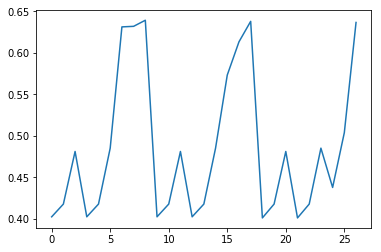

In [49]:
scores = clf.cv_results_['mean_test_score']
plt.plot(scores)

## Machine
Intel core i5 7th generation
RAM 16Gb 

In [50]:
dists_test, indices_test = lshf_best.kneighbors(data_hashing)

In [51]:
np.sum(indices_brutal == indices_test) / indices_test.size

0.3006666666666667